# [2/2] Molecular lipophilicity prediction with PyTorch

**NOTE** <br>
This dataset has already been explored, and feature engineering has been performed in the previous notebook "lipo_pred_ML". The purpose of this notebook is to utilize the PyTorch framework to construct a simple neural network. Following that, I will compare the metrics with those obtained from the previous best Random Forest model.

In [1]:
# importing libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#warnings.filterwarnings("ignore")

In [2]:
# importing the dataset
df = pd.read_csv('df.csv')
df.head()

,smiles,logP,mol,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_S_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_F_atoms,num_of_I_atoms,num_of_Br_atoms,num_of_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_H_donors,num_H_acceptors
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x1409af880>,4,0,0,0,2,0,0,0,0,14,0.00,126.000306,38,2,0,0
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x1409ae920>,3,0,1,0,0,0,0,0,1,11,26.02,134.968361,30,2,1,1
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x1409aea40>,4,1,0,0,0,0,0,0,1,15,20.23,151.983677,38,2,1,1
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x1409aeaa0>,6,1,0,0,0,0,0,0,0,21,20.23,108.124594,44,1,1,1
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x1409aeb00>,5,1,0,0,0,1,0,0,0,20,9.23,120.070402,44,2,0,1


Let's preprocess the dataset:

In [4]:
# importing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Remove 'mol' and 'smiles' columns from df
df = df.drop(columns=['mol', 'smiles'])

# Split the dataframe in features (X) and target (y)
X = df.drop(columns=['logP'])
y = df['logP']

# Let's train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


# StandardScaler definition
scaler = StandardScaler()

# Fittin the scaler on X_train
X_train = scaler.fit_transform(X_train)

# Transforming the X_test
X_test = scaler.transform(X_test)

PyTorch utilizes tensors instead of simple arrays. Therefore, numpy arrays need to be converted into tensors:

In [5]:
# Importing library
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Converting arrays into tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Checking the shape
X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([13149, 16]),
 torch.Size([13149, 1]),
 torch.Size([1461, 16]),
 torch.Size([1461, 1]))

In order to improve performance, it's a good practice to define a Dataset class and DataLoaders:

In [22]:
# Importing libraries
from torch.utils.data import Dataset, DataLoader

# Defining the dataset
class LipoDataset(Dataset):

    def __init__(self, X_tensor, y_tensor):
     
        self.x_data = X_tensor
        self.y_data = y_tensor

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        
        return self.y_data.shape[0]

train_dataset = LipoDataset(X_train_tensor, y_train_tensor)
test_dataset = LipoDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=False, num_workers=0)

Let's define the hyperparameters of the model and its architecture. For this task, I will opt for a simple fully connected neural network with 2 hidden layers, followed by the ReLU activation function:

In [23]:
import torch.nn as nn
import torch.nn.functional as F

# Hyper-parameters 
num_epochs = 50
batch_size = 4
learning_rate = 0.001
n_input_features = 16

class NeuralNetwork(nn.Module):
    def __init__(self, n_input_features):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(n_input_features, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x): 
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)                       
        return x

# Initializing the model
model = NeuralNetwork(n_input_features).to(device)

# Defining the loss criterion and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

The following funtions are useful to calculate the error metrics:

In [24]:
def MAE(true, predicted):
    return torch.mean(torch.abs(true - predicted))

def RMSE(true, predicted):
    return torch.sqrt(torch.mean((true - predicted) ** 2))


Now, let's train the model:

In [18]:
train_losses = []
train_maes = []
train_rmses = []

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    train_loss = 0.0
    train_mae = 0.0
    train_rmse = 0.0
    
    for i, (inputs, targets) in enumerate(train_loader):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_mae += MAE(targets, outputs).item()
        train_rmse += RMSE(targets, outputs).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_train_mae = train_mae / len(train_loader)
    avg_train_rmse = train_rmse / len(train_loader)

    train_losses.append(avg_train_loss)
    train_maes.append(avg_train_mae)
    train_rmses.append(avg_train_rmse)

    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, MAE: {avg_train_mae:.4f}, RMSE: {avg_train_rmse:.4f}')

print('Finished Training')


Epoch [1/50], Loss: 0.2288, MAE: 0.3479, RMSE: 0.4411
Epoch [2/50], Loss: 0.1687, MAE: 0.3089, RMSE: 0.3925
Epoch [3/50], Loss: 0.1636, MAE: 0.3042, RMSE: 0.3862
Epoch [4/50], Loss: 0.1583, MAE: 0.2987, RMSE: 0.3802
Epoch [5/50], Loss: 0.1559, MAE: 0.2976, RMSE: 0.3785
Epoch [6/50], Loss: 0.1525, MAE: 0.2944, RMSE: 0.3753
Epoch [7/50], Loss: 0.1501, MAE: 0.2921, RMSE: 0.3705
Epoch [8/50], Loss: 0.1474, MAE: 0.2895, RMSE: 0.3674
Epoch [9/50], Loss: 0.1464, MAE: 0.2881, RMSE: 0.3667
Epoch [10/50], Loss: 0.1432, MAE: 0.2861, RMSE: 0.3618
Epoch [11/50], Loss: 0.1417, MAE: 0.2839, RMSE: 0.3607
Epoch [12/50], Loss: 0.1404, MAE: 0.2824, RMSE: 0.3589
Epoch [13/50], Loss: 0.1391, MAE: 0.2812, RMSE: 0.3578
Epoch [14/50], Loss: 0.1378, MAE: 0.2802, RMSE: 0.3550
Epoch [15/50], Loss: 0.1358, MAE: 0.2781, RMSE: 0.3536
Epoch [16/50], Loss: 0.1360, MAE: 0.2790, RMSE: 0.3535
Epoch [17/50], Loss: 0.1337, MAE: 0.2759, RMSE: 0.3506
Epoch [18/50], Loss: 0.1331, MAE: 0.2764, RMSE: 0.3504
Epoch [19/50], Loss

I'm plotting the MAE, RMSE and the loss:

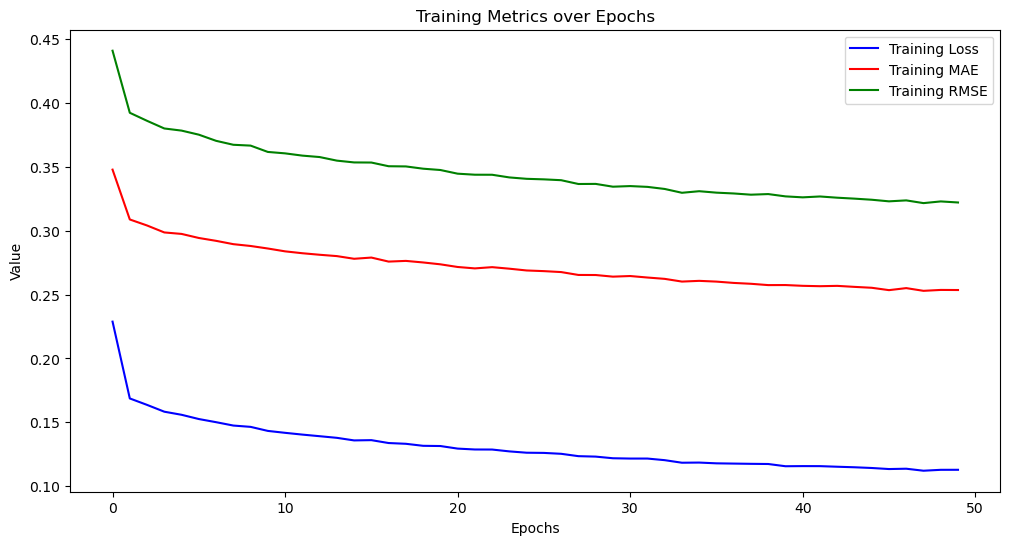

In [19]:
plt.figure(figsize=(12, 6))

# Plotting the training loss
plt.plot(train_losses, label='Training Loss', color='blue')

# Plotting the training MAE
plt.plot(train_maes, label='Training MAE', color='red')

# Plotting the training RMSE
plt.plot(train_rmses, label='Training RMSE', color='green')

plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Metrics over Epochs')
plt.legend()
plt.show()


Observing the plot, we can deduce that the loss decreases very quickly during the first epochs, and then it starts to slow down. Around 50 epochs, it appears to converge. The same pattern holds true for MAE and RMSE.

It's time to evaluate the model:

In [20]:
test_mae = 0.0
test_rmse = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        
        test_mae += MAE(targets, outputs).item()
        test_rmse += RMSE(targets, outputs).item()

avg_test_mae = test_mae / len(test_loader)
avg_test_rmse = test_rmse / len(test_loader)

print(f"Test MAE: {avg_test_mae:.4f}, Test RMSE: {avg_test_rmse:.4f}")


Test MAE: 0.2837, Test RMSE: 0.3647


The metric scores of the test set appear to be comparable to the ones of the training set. However, there is a slight indication of potential overfitting. Moving forward, the metrics obtained with this neural network are remarkably close to the ones acquired from the Random Forest (MAE = 0.28, RMSE = 0.38). This implies that the two models exhibit similar performance.

The subsequent step would involve tuning the hyperparameters of this neural network to ascertain whether improved scores could be attained. Nonetheless, I believe it might be more beneficial to allocate additional time to feature engineering. This approach could potentially yield better results with less computational effort.